# **Example GLAM3 | Impacts of land occupation and transformation on biodiversity**

**Authors:**
[Romain Sacchi](mailto:romain.sacchi@psi.ch)
[Alvaro Hahn Menacho](mailto:alvaro.hahn-menacho@psi.ch)

This notebook presents an example to obtain an exchange-based LCA score using the [Biodiversity impacts](https://pubs.acs.org/doi/full/10.1021/acs.est.3c04191) method developed by Scherrer et al., 2023. The method is implemented in the `edges` package and can be used in `brightway2` and `brightway25` via the `EdgeLCIA` class.

The method, when used, should be cited as follows:

Scherer L, Rosa F, Sun Z, et al (2023)
Biodiversity Impact Assessment Considering Land Use Intensities and Fragmentation.
Environ Sci Technol https://doi.org/10.1021/acs.est.3c04191


## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA](#sec_run_edges_lca)
5. [Export results](#sec_export_results)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import the ``edges`` and set up a ``brightway`` project

In [1]:
import pandas as pd

from edges import EdgeLCIA, get_available_methods, setup_package_logging
import logging
import bw2data, bw2io

# we want the logger to log things into edges.log
setup_package_logging(level=logging.INFO)
# if you want full debug:
#setup_package_logging(level=logging.DEBUG)

For our example, we activate a ``brighway`` project that contains ecoinvent 3.10 cut-off.

In [2]:
bw2data.projects.set_current("test_severin")
# bw2data.projects.set_current("ecoinvent-3.10-cutoff")

In [3]:
bw2data.databases

Databases dictionary with 4 object(s):
	biosphere
	biosphere3
	ecoinvent-3.10.1-cutoff
	h2_pem

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

To illustrate our water footprint case, we need to import some inventories representing the production of hydrogen using a PEM electrolyzer, powered with offshore wind power in France. The inventories are provided in this repository (``lci-hydrogen-electrolysis-ei310.xlsx``).

In [4]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis-ei310.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10.1-cutoff",fields=["name", "reference product", "location"])
lci.match_database("biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()

# we assign manually classifications to activities
# since it is unclear how to do that in the Excel inventory file.

classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()


Extracted 1 worksheets in 0.18 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 11.87 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


Applying strategy: link_iterable_by_fields
11 datasets
214 exchanges
0 unlinked exchanges
  
Applying strategy: drop_unlinked
Applied 1 strategies in 0.00 seconds


0% [###########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/13/2025 20:21:01
  Finished: 12/13/2025 20:21:01
  Total time elapsed: 00:00:00
  CPU %: 50.40
  Memory %: 1.92
Created database: h2_pem


<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU
We select the activity to run the LCA for. In our case, it is the production of 1 kg of hydrogen, using a PEM electrolyzer, powered with offshore wind power, in France.

In [5]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method
``edges`` comes with a numbers of LCIA methods. You can list them using the `get_available_methods()` function.
We currently have several flavors of `GLAM3 biodiversity`:

* 'GLAM3', 'biodiversity', 'occupation', 'average', 'amphibians'
* 'GLAM3', 'biodiversity', 'occupation', 'average', 'birds'
* 'GLAM3', 'biodiversity', 'occupation', 'average', 'eukaryota'
* 'GLAM3', 'biodiversity', 'occupation', 'average', 'mammals'
* 'GLAM3', 'biodiversity', 'occupation', 'average', 'plants'
* 'GLAM3', 'biodiversity', 'occupation', 'average', 'reptiles'
* 'GLAM3', 'biodiversity', 'transformation', 'average', 'amphibians'
* 'GLAM3', 'biodiversity', 'transformation', 'average', 'birds'
* 'GLAM3', 'biodiversity', 'transformation', 'average', 'eukaryota'
* 'GLAM3', 'biodiversity', 'transformation', 'average', 'mammals'
* 'GLAM3', 'biodiversity', 'transformation', 'average', 'plants'
* 'GLAM3', 'biodiversity', 'transformation', 'average', 'reptiles'


These methods present different scopes:

* Occupation CFs (in PDF·m²⁻¹) quantify impacts per unit area and time of land occupation.
* Transformation CFs (in PDF·yr·m²⁻¹) quantify impacts per unit area transformed, accounting for regeneration time.
* CFs are provided as average, at country level, with ecoregion-specific CFs for sensitivity purpose, across five biome types.
* The CFs integrate land fragmentation (via the Equivalent Connected Area, ECA) and land use intensity—both drivers of biodiversity loss not jointly included in earlier models.
* CFs cannot be used to assess changes in fragmentation degree, as fragmentation is internally parameterized.
* The Eukaryota CFs represent an aggregated proxy combining plants and vertebrates (amphibians, birds, mammals, reptiles), each weighted equally. They thus serve as a generic biodiversity indicator for overall potential species loss across taxa.

For more information about its implementation and use, refer to [the page about](https://edges.readthedocs.io/en/latest/methods.html#glam3-land-use-impacts-on-biodiversity) `GLAM3 biodiversity` in the ``edges`` documentation, and for more information about the method itself, refer to:

Scherer L, Rosa F, Sun Z, et al (2023)
Biodiversity Impact Assessment Considering Land Use Intensities and Fragmentation.
Environ Sci Technol https://doi.org/10.1021/acs.est.3c04191


In [6]:
get_available_methods()

[('AWARE 2.0', 'Country', 'all', 'yearly'),
 ('AWARE 2.0', 'Country', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'non', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'unspecified', 'yearly'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'amphibians'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'birds'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'eukaryota'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'mammals'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'plants'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'reptiles'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'amphibians'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'birds'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'eukaryota'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'mammals'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'plants'),
 ('GLAM3', 'biodiversity', 'transformation', 'average', 'reptiles'),
 ('GeoPol

In [7]:
methods = [
    ('GLAM3', 'biodiversity', 'occupation', 'average', 'amphibians'),
    ('GLAM3', 'biodiversity', 'occupation', 'average', 'birds'),
    # ('GLAM3', 'biodiversity', 'occupation', 'average', 'eukaryota'), <- we remove the eukaryota indicator as it is an aggregate of the other five
    ('GLAM3', 'biodiversity', 'occupation', 'average', 'mammals'),
    ('GLAM3', 'biodiversity', 'occupation', 'average', 'plants'),
    ('GLAM3', 'biodiversity', 'occupation', 'average', 'reptiles'),
]
methods

[('GLAM3', 'biodiversity', 'occupation', 'average', 'amphibians'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'birds'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'mammals'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'plants'),
 ('GLAM3', 'biodiversity', 'occupation', 'average', 'reptiles')]

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA

In [8]:
import pandas as pd

main_df = pd.DataFrame()

for method in methods:
    # we instantiate EdgeLCIA, which builds on the `bw2calc.LCA` class
    LCA = EdgeLCIA(
        demand={act: 1}, # <- we define a functional unit
        method=method, # <- we specify the LCIA method
        use_distributions=True, # <- we want to consider variability across ecoregions
        iterations=10000 # <- we specific the number of iterations
    )

    # apply strategies
    LCA.apply_strategies()
    LCA.evaluate_cfs()
    LCA.lcia()

    df = LCA.generate_cf_table()
    df["method"] = " ".join(method)
    main_df = pd.concat([main_df, df], ignore_index=True)

Processing global groups (pass 1): 100%|██████████| 17/17 [00:00<00:00, 17074.51it/s]


In [ ]:
print(LCA.statistics())

In [23]:
main_df = main_df.replace("GLAM3 biodiversity occupation average ", "", regex=True)
main_df.to_pickle("lca_occupation_results_old.pkl")
print("Dataframe saved successfully!")
main_df.columns

Dataframe saved successfully!


Index(['supplier name', 'supplier categories', 'consumer name',
       'consumer reference product', 'consumer location', 'consumer cpc',
       'consumer ecospold01categories', 'consumer isic rev.4 ecoinvent',
       'amount', 'CF (mean)', 'CF (std)', 'CF (min)', 'CF (5th)', 'CF (25th)',
       'CF (50th)', 'CF (75th)', 'CF (95th)', 'CF (max)', 'impact (mean)',
       'impact (std)', 'impact (min)', 'impact (5th)', 'impact (25th)',
       'impact (50th)', 'impact (75th)', 'impact (95th)', 'impact (max)',
       'method'],
      dtype='object')

In [24]:
main_df = pd.read_pickle("lca_occupation_results_old.pkl")
print("Dataframe loaded!")

Dataframe loaded!


### Plot test_severin graphs

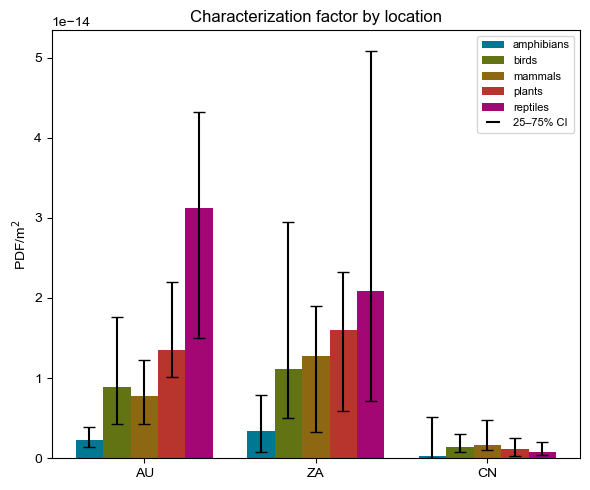

In [33]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# --- User Configuration ---
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"] 

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

cutoff = 0.00

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# --- Shared Data Prep ---
df_table = main_df.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()
df_net = df.copy()

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns

# Calculate Location Order (Standard Top 5)
d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d.sort_values(by="amount", ascending=False)
loc_order = ['AU', 'ZA', 'CN']

# =========================================================
# PLOT B: Characterization factor by location
# =========================================================
fig, ax_b = plt.subplots(figsize=(6, 5)) 

df_b = main_df.copy()

# Pick available CF columns
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

# Restrict to the customized loc_order
gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    # This .reindex(loc_order) ensures we try to grab 'AU' data specifically
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    
    # Custom colors
    bar_color = custom_colors[i % len(custom_colors)]
    
    ax_b.bar(positions, y, yerr=cf_errors, capsize=4, width=bar_width, 
             label=str(meth), color=bar_color)

ax_b.set_title("Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_location_old.png", dpi=150)
plt.show()

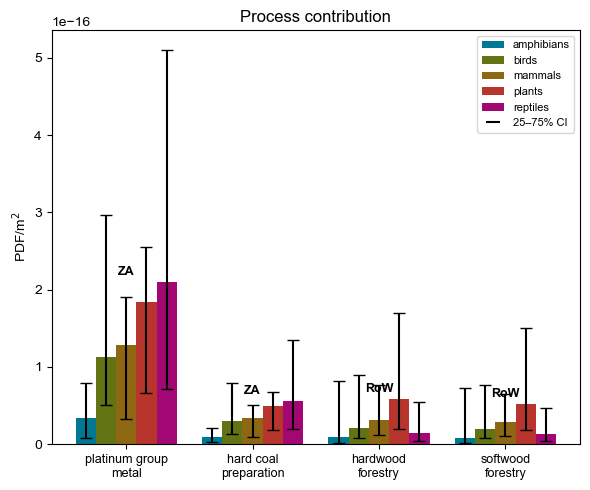

In [32]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# --- User Configuration ---
# REPLACE THESE WITH YOUR EXACT HEX CODES
# Ensure you have as many colors as you have methods
custom_colors = ["#007894", "#627313", "#8e6713", "#b7352d", "#a30774"]

# --- Style Settings ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 10
})

# --- Legend Helper ---
errorbar_legend = Line2D(
    [0], [0], color='black', linestyle='none', marker='_',
    markersize=10, markeredgewidth=1.5, label='25–75% CI'
)

# =========================================================
# PLOT C: Process contribution
# =========================================================
fig, ax_c = plt.subplots(figsize=(6, 5))

# --- Data Prep ---
df_c = main_df.copy()
df_c["consumer name"] = df_c["consumer name"].str.split(", ").str[0]
df_c["label"] = df_c["consumer name"] + " (" + df_c["consumer location"] + ")"

# Flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_imp_percentiles = f"impact {lower_percentile}" in df_c.columns and f"impact {top_percentile}" in df_c.columns

# Select top 4 labels by total mean impact
top_labels = (df_c.groupby("label", as_index=False)["impact (50th)"]
                .sum(numeric_only=True)
                .sort_values("impact (50th)", ascending=False)
                .head(4)["label"]
                .tolist())

# Aggregation dict
agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

# Group and aggregate
gb_c = (df_c[df_c["label"].isin(top_labels)]
        .groupby(["label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["label"] = pd.Categorical(gb_c["label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# Per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("label") for m in methods_c}

# --- Plotting Loop ---
for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        err_lower = y - vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        err_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    
    # --- COLOR SELECTION LOGIC ---
    bar_color = custom_colors[i % len(custom_colors)]

    ax_c.bar(positions, y, yerr=errors, capsize=4, width=bar_width_c, 
             label=str(meth), color=bar_color)

# --- Formatting ---
short_labels = pd.Series(top_labels).str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = pd.Series(top_labels).str.extract(r"\(([^)]+)\)$")[0]
short_labels = [lbl.rsplit(" ", 1)[0] + "\n" + lbl.rsplit(" ", 1)[1] if " " in lbl else lbl
                for lbl in short_labels]
short_labels = [lbl.replace("deionized", "").replace("gravel and sand ", "") for lbl in short_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(short_labels, rotation=0, ha="center", size=9)
ax_c.set_title("Process contribution")
ax_c.set_ylabel("PDF/m$^2$")

# Annotate Country Codes
cluster_tops = []
for j in range(len(x_c)):
    ys = []
    for meth in methods_c:
        vals = c_dict[meth].reindex(top_labels)
        ys.append(vals["impact (50th)"].values[j] if j < len(vals) else np.nan)
    cluster_tops.append(np.nanmax(ys))

for xi, yi, code in zip(x_c, cluster_tops, countries):
    if pd.notna(yi):
        ax_c.annotate(code, (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, fontweight='bold')

# Legend
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("plots/occupation_CFs_by_process_old.png", dpi=150)
plt.show()

<a id="sec_plot_results"></a>
# 6. Plot results
Script used to produce Figure 2 in the Sacchi et al. 2025 article.

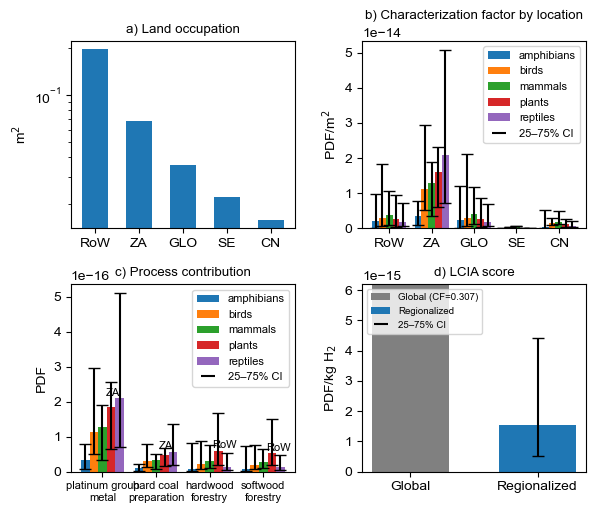

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

cutoff = 0.00

# --- Figure & style (2 x 2 layout) ---
fig, axes = plt.subplots(2, 2, figsize=(6, 5.5))
ax_a, ax_b = axes[0, 0], axes[0, 1]
ax_c, ax_d = axes[1, 0], axes[1, 1]

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 8
})

# Legend entry for CI 25–75
errorbar_legend = Line2D(
    [0], [0],
    color='black',
    linestyle='none',
    marker='_',
    markersize=10,
    markeredgewidth=1.5,
    label='25–75% CI'
)

# --- Prep / filtering ---
df_table = main_df.copy()
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m].copy()

# Needed for (a): sign of amount by CF sign (if you want "net")
df_net = df.copy()
# Common percentile flags
lower_percentile = "(25th)"
top_percentile = "(75th)"
has_cf_percentiles = f"CF {lower_percentile}" in df.columns and f"CF {top_percentile}" in df.columns
has_imp_percentiles = f"impact {lower_percentile}" in df.columns and f"impact {top_percentile}" in df.columns

# =========================================================
# (a) Land occupation — top-5 locations by (signed) amount
# =========================================================
d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d.sort_values(by="amount", ascending=False).head(5)

d["amount"].plot(kind="bar", ax=ax_a, xlabel='', width=0.6)
ax_a.set_title("a) Land occupation")
ax_a.set_ylabel("m$^2$")
ax_a.set_xticks(range(len(d)))
ax_a.set_xticklabels(d.index, rotation=0)
ax_a.set_yscale('log')

# Keep consistent order of locations from (a)
loc_order = d.index.tolist()

# =========================================================
# (b) Characterization factor by location — CLUSTERED by method
# =========================================================
df_b = main_df.copy()

# Keep percentiles bracketing the mean


# Pick available CF columns safely
cf_cols = ["CF (mean)", f"CF {lower_percentile}", "CF (50th)", f"CF {top_percentile}"]
cf_cols = [c for c in cf_cols if c in df_b.columns]

# Aggregate correctly (select cols FIRST, then .mean())
gb_b = (
    df_b
    .groupby(["consumer location", "method"])[cf_cols]
    .mean(numeric_only=True)
    .reset_index()
)

# Restrict to (a)'s locations, preserve order
gb_b = gb_b[gb_b["consumer location"].isin(loc_order)]
gb_b["consumer location"] = pd.Categorical(gb_b["consumer location"], categories=loc_order, ordered=True)
gb_b = gb_b.sort_values(["consumer location", "method"])

methods_b = list(gb_b["method"].unique())
n_methods_b = max(1, len(methods_b))
x = np.arange(len(loc_order))
bar_width = min(0.8 / n_methods_b, 0.25)

# per-method lookup
b_dict = {m: gb_b[gb_b["method"] == m].set_index("consumer location") for m in methods_b}

for i, meth in enumerate(methods_b):
    vals = b_dict[meth].reindex(loc_order)
    y = vals["CF (50th)"].values

    if has_cf_percentiles:
        lower = y - vals[f"CF {lower_percentile}"].values
        upper = vals[f"CF {top_percentile}"].values - y
        cf_errors = np.clip(np.vstack([lower, upper]), 0, None)
    else:
        cf_errors = None

    positions = x - (n_methods_b - 1) * bar_width / 2 + i * bar_width
    ax_b.bar(positions, y, yerr=cf_errors, capsize=4, width=bar_width, label=str(meth))

ax_b.set_title("b) Characterization factor by location")
ax_b.set_ylabel("PDF/m$^2$")
ax_b.set_xticks(x)
ax_b.set_xticklabels(loc_order, rotation=0)

# Legend: methods + CI marker
handles_b, labels_b = ax_b.get_legend_handles_labels()
handles_b.append(errorbar_legend)
labels_b.append('25–75% CI')
ax_b.legend(handles=handles_b, labels=labels_b, loc='upper right', fontsize=8)

# =========================================================
# (c) Process contribution — CLUSTERED by method (top-4 labels)
# =========================================================
df_c = main_df.copy()
df_c["consumer name"] = df_c["consumer name"].str.split(", ").str[0]
df_c["label"] = df_c["consumer name"] + " (" + df_c["consumer location"] + ")"

# Select top 4 labels by total mean impact (across methods)
top_labels = (df_c.groupby("label", as_index=False)["impact (50th)"]
                .sum(numeric_only=True)
                .sort_values("impact (50th)", ascending=False)
                .head(4)["label"]
                .tolist())

agg_c = {"impact (50th)": "sum"}
if has_imp_percentiles:
    agg_c[f"impact {lower_percentile}"] = "sum"
    agg_c[f"impact {top_percentile}"] = "sum"

gb_c = (df_c[df_c["label"].isin(top_labels)]
        .groupby(["label", "method"])
        .agg(agg_c)
        .reset_index())

gb_c["label"] = pd.Categorical(gb_c["label"], categories=top_labels, ordered=True)
gb_c = gb_c.sort_values(["label", "method"])

methods_c = list(gb_c["method"].unique())
n_methods_c = max(1, len(methods_c))
x_c = np.arange(len(top_labels))
bar_width_c = min(0.8 / n_methods_c, 0.25)

# per-method lookup
c_dict = {m: gb_c[gb_c["method"] == m].set_index("label") for m in methods_c}

for i, meth in enumerate(methods_c):
    vals = c_dict[meth].reindex(top_labels)
    y = vals["impact (50th)"].values

    if has_imp_percentiles:
        err_lower = y - vals.get(f"impact {lower_percentile}", pd.Series(index=vals.index, dtype=float)).values
        err_upper = vals.get(f"impact {top_percentile}", pd.Series(index=vals.index, dtype=float)).values - y
        errors = np.clip(np.vstack([err_lower, err_upper]), 0, None)
    else:
        errors = None

    positions = x_c - (n_methods_c - 1) * bar_width_c / 2 + i * bar_width_c
    ax_c.bar(positions, y, yerr=errors, capsize=4, width=bar_width_c, label=str(meth))

# Tidy labels (shorten + line break), and annotate with country codes at cluster top
short_labels = pd.Series(top_labels).str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = pd.Series(top_labels).str.extract(r"\(([^)]+)\)$")[0]
short_labels = [lbl.rsplit(" ", 1)[0] + "\n" + lbl.rsplit(" ", 1)[1] if " " in lbl else lbl
                for lbl in short_labels]
short_labels = [lbl.replace("deionized", "").replace("gravel and sand ", "") for lbl in short_labels]

ax_c.set_xticks(x_c)
ax_c.set_xticklabels(short_labels, rotation=0, ha="center", size=7)
ax_c.set_title("c) Process contribution")
ax_c.set_ylabel("PDF")
ax_c.tick_params(axis="x", labelsize=8)

# annotate with country code over the tallest bar in each cluster
cluster_tops = []
for j in range(len(x_c)):
    ys = []
    for meth in methods_c:
        vals = c_dict[meth].reindex(top_labels)
        ys.append(vals["impact (50th)"].values[j] if j < len(vals) else np.nan)
    cluster_tops.append(np.nanmax(ys))
for xi, yi, code in zip(x_c, cluster_tops, countries):
    if pd.notna(yi):
        ax_c.annotate(code, (xi, yi), textcoords="offset points", xytext=(2, 2), ha='left', fontsize=8)

# Legend: methods + CI marker
handles_c, labels_c = ax_c.get_legend_handles_labels()
handles_c.append(errorbar_legend)
labels_c.append('25–75% CI')
ax_c.legend(handles=handles_c, labels=labels_c, loc='upper right', fontsize=8)

# =========================================================
# (d) LCIA score — Global vs Regionalized
# =========================================================
from io import StringIO

# --- 1) Put your CF table into a small DataFrame ---
cf_text = """species_group	kingdom	habitat_id	habitat	CF_occ_avg_glo
Amphibians	Animalia	2.5	Cropland_LightIntense	3.70E-12
Amphibians	Animalia	4	Cropland_Minimal	2.19E-12
Amphibians	Animalia	5	Managed_forest_Intense	1.87E-12
Amphibians	Animalia	6	Managed_forest_Light	6.75E-13
Amphibians	Animalia	7	Managed_forest_Minimal	1.63E-13
Amphibians	Animalia	8.5	Pasture_LightIntense	3.08E-12
Amphibians	Animalia	10	Pasture_Minimal	5.03E-11
Amphibians	Animalia	11.5	Plantation_LightIntense	8.15E-12
Amphibians	Animalia	13	Plantation_Minimal	6.24E-12
Amphibians	Animalia	14	Urban_Intense	7.51E-12
Amphibians	Animalia	15	Urban_Light	6.60E-12
Amphibians	Animalia	16	Urban_Minimal	5.80E-12
Birds	Animalia	2.5	Cropland_LightIntense	2.18E-12
Birds	Animalia	4	Cropland_Minimal	1.42E-12
Birds	Animalia	5	Managed_forest_Intense	9.01E-13
Birds	Animalia	6	Managed_forest_Light	3.12E-13
Birds	Animalia	7	Managed_forest_Minimal	7.20E-14
Birds	Animalia	8.5	Pasture_LightIntense	1.88E-12
Birds	Animalia	10	Pasture_Minimal	2.20E-12
Birds	Animalia	11.5	Plantation_LightIntense	3.32E-12
Birds	Animalia	13	Plantation_Minimal	2.83E-12
Birds	Animalia	14	Urban_Intense	4.20E-12
Birds	Animalia	15	Urban_Light	3.67E-12
Birds	Animalia	16	Urban_Minimal	3.12E-12
Mammals	Animalia	2.5	Cropland_LightIntense	2.80E-12
Mammals	Animalia	4	Cropland_Minimal	1.84E-12
Mammals	Animalia	5	Managed_forest_Intense	1.08E-12
Mammals	Animalia	6	Managed_forest_Light	4.02E-13
Mammals	Animalia	7	Managed_forest_Minimal	9.57E-14
Mammals	Animalia	8.5	Pasture_LightIntense	2.22E-12
Mammals	Animalia	10	Pasture_Minimal	2.65E-12
Mammals	Animalia	11.5	Plantation_LightIntense	4.42E-12
Mammals	Animalia	13	Plantation_Minimal	3.54E-12
Mammals	Animalia	14	Urban_Intense	4.92E-12
Mammals	Animalia	15	Urban_Light	4.24E-12
Mammals	Animalia	16	Urban_Minimal	3.66E-12
Reptiles	Animalia	2.5	Cropland_LightIntense	3.93E-12
Reptiles	Animalia	4	Cropland_Minimal	2.56E-12
Reptiles	Animalia	5	Managed_forest_Intense	1.65E-12
Reptiles	Animalia	6	Managed_forest_Light	6.17E-13
Reptiles	Animalia	7	Managed_forest_Minimal	1.46E-13
Reptiles	Animalia	8.5	Pasture_LightIntense	3.08E-12
Reptiles	Animalia	10	Pasture_Minimal	2.57E-11
Reptiles	Animalia	11.5	Plantation_LightIntense	7.66E-12
Reptiles	Animalia	13	Plantation_Minimal	5.91E-12
Reptiles	Animalia	14	Urban_Intense	7.31E-12
Reptiles	Animalia	15	Urban_Light	6.76E-12
Reptiles	Animalia	16	Urban_Minimal	6.36E-12
Plants	Plantae	2	Cropland_Intense	3.75E-12
Plants	Plantae	3	Cropland_Light	2.46E-12
Plants	Plantae	4	Cropland_Minimal	1.93E-12
Plants	Plantae	5	Managed_forest_Intense	2.90E-12
Plants	Plantae	6	Managed_forest_Light	1.82E-12
Plants	Plantae	7	Managed_forest_Minimal	7.24E-13
Plants	Plantae	8	Pasture_Intense	3.20E-12
Plants	Plantae	9	Pasture_Light	1.68E-12
Plants	Plantae	10	Pasture_Minimal	7.73E-13
Plants	Plantae	11	Plantation_Intense	5.68E-12
Plants	Plantae	12.5	Plantation_MinimalLight	3.96E-12
Plants	Plantae	14	Urban_Intense	5.84E-12
Plants	Plantae	15	Urban_Light	2.62E-13
Plants	Plantae	16	Urban_Minimal	0
"""
cf_df = pd.read_csv(StringIO(cf_text), sep=r"\s+", engine="python")

# --- 2) Aggregate to one CF per habitat ---
# Choice: mean across species groups (change to .sum() if you want to sum taxa)
cf_by_habitat = (cf_df.groupby("habitat")["CF_occ_avg_glo"]
                        .mean())  # or .sum()

# --- 3) Your flow→habitat mapping ---
occupation_flows = {
    'Occupation, annual crop': 'Cropland_Intense',
    'Occupation, annual crop, flooded crop': 'Cropland_Intense',
    'Occupation, annual crop, greenhouse': 'Urban_Light',
    'Occupation, annual crop, irrigated': 'Cropland_Intense',
    'Occupation, annual crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, annual crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Occupation, arable land, unspecified use': 'Cropland_Intense',
    'Occupation, construction site': 'Urban_Intense',
    'Occupation, cropland fallow (non-use)': 'Cropland_Minimal',
    'Occupation, dump site': 'Urban_Intense',
    'Occupation, field margin/hedgerow': 'Cropland_Minimal',
    'Occupation, forest, extensive': 'Pasture_Light',
    'Occupation, forest, intensive': 'Managed_forest_Intense',
    'Occupation, forest, primary (non-use)': 'Managed_forest_Minimal',
    'Occupation, forest, secondary (non-use)': 'Pasture_Light',
    'Occupation, forest, unspecified': 'Managed_forest_Intense',
    'Occupation, grassland, natural (non-use)': 'Pasture_Minimal',
    'Occupation, grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Occupation, heterogeneous, agricultural': 'Cropland_Minimal',
    'Occupation, industrial area': 'Urban_Intense',
    'Occupation, mineral extraction site': 'Urban_Intense',
    'Occupation, pasture, man made': 'Pasture_Intense',
    'Occupation, pasture, man made, extensive': 'Pasture_Light',
    'Occupation, pasture, man made, intensive': 'Pasture_Intense',
    'Occupation, permanent crop': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    'Occupation, shrub land, sclerophyllous': 'Managed_forest_Minimal',
    'Occupation, traffic area, rail network': 'Urban_Intense',
    'Occupation, traffic area, rail/road embankment': 'Urban_Light',
    'Occupation, traffic area, road network': 'Urban_Intense',
    'Occupation, unspecified': 'Urban_Intense',
    'Occupation, unspecified, natural (non-use)': 'Pasture_Minimal',
    'Occupation, urban, continuously built': 'Urban_Intense',
    'Occupation, urban, discontinuously built': 'Urban_Light',
    'Occupation, urban, green area': 'Urban_Minimal',
    'Occupation, urban/industrial fallow (non-use)': 'Urban_Light',
}

# --- 4) Build the Global df using the mapping (replaces your 0.307 line) ---
df_global = df_table.copy()

# Map flow name -> habitat key (assuming the occupation flow name is in 'supplier name')
df_global["habitat_key"] = df_global["supplier name"].map(occupation_flows)

# Map habitat -> CF value from lookup
df_global["CF (50th)"] = df_global["habitat_key"].map(cf_by_habitat)

# Fallback for flows that didn't map (keep a constant so the plot doesn't break)
fallback_cf = 0.0  # or a small default like 0.0; set to np.nan if you prefer to drop them
df_global["CF (50th)"] = df_global["CF (50th)"].fillna(fallback_cf)

# Recompute impact for Global case
df_global["impact (50th)"] = df_global["amount"] * df_global["CF (50th)"]

# This is what you will plot as "Global" in (d):
total_global = df_global["impact (50th)"].sum()


total_regionalized = df_table.copy()
regional_mean = total_regionalized["impact (50th)"].sum()
regional_min = total_regionalized[f"impact {lower_percentile}"].sum() if has_imp_percentiles else regional_mean
regional_max = total_regionalized[f"impact {top_percentile}"].sum() if has_imp_percentiles else regional_mean

ax_d.bar(["Global"], [total_global], color="gray", label="Global (CF=0.307)", width=.6)
ax_d.bar(
    1,
    regional_mean,
    yerr=None if not has_imp_percentiles else [[np.clip(regional_mean - regional_min, 0, None)],
                                               [np.clip(regional_max - regional_mean, 0, None)]],
    capsize=4,
    width=.6,
    label='Regionalized'
)

ax_d.set_title("d) LCIA score")
ax_d.set_ylabel("PDF/kg H$_2$")
ax_d.set_ylim(0, regional_mean * 4
              )
ax_d.set_xticks([0, 1])
ax_d.set_xticklabels(["Global", "Regionalized"])

handles_d, labels_d = ax_d.get_legend_handles_labels()
if has_imp_percentiles:
    handles_d.append(errorbar_legend)
    labels_d.append('25–75% CI')
ax_d.legend(handles=handles_d, labels=labels_d, loc='upper left', fontsize=7)

# --- Layout & export ---
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig("figure_1.png", bbox_inches="tight", dpi=150)
plt.show()
